<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/VAE_SwissRoll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
# 1. Data
n_samples = 2000
X, t = make_swiss_roll(n_samples, noise=0.0)
t_est = np.sqrt(X[:,0]**2 + X[:,2]**2)
X = StandardScaler().fit_transform(X)
input_dim = X.shape[1]
latent_dim = 2

In [11]:
# 2. Encoder
encoder_inputs = keras.Input(shape=(input_dim,))
x = layers.Dense(128, activation="relu")(encoder_inputs)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [13]:
# 3. Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
decoder_outputs = layers.Dense(input_dim, activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [17]:
# 4. Subclassed VAE Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            rec_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=1))
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = rec_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.compiled_metrics.update_state(data, reconstruction)
        return {"loss": total_loss, "reconstruction_loss": rec_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

vae = VAE(encoder, decoder)
vae.compile(optimizer="adam", loss="mse")

In [18]:
# 5. Train
vae.fit(X, X, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:642: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - kl_loss: 0.4242 - loss: 2.8017 - reconstruction_loss: 2.3774 - val_loss: 0.7172
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.6375 - loss: 2.6797 - reconstruction_loss: 2.0421 - val_loss: 0.6625
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.7657 - loss: 2.6579 - reconstruction_loss: 1.8922 - val_loss: 0.6142
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.8095 - loss: 2.6730 - reconstruction_loss: 1.8635 - val_loss: 0.6106
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.8015 - loss: 2.6749 - reconstruction_loss: 1.8734 - val_loss: 0.5973
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.7890 - loss: 2.5914 - reconstruction_loss: 1.8024 - val_loss: 0.5820
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.7811 - loss: 2.5825 - reconstruction_loss: 1.8014 - val_loss: 0.6035
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - kl_loss: 0.8075 - loss: 2.61

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


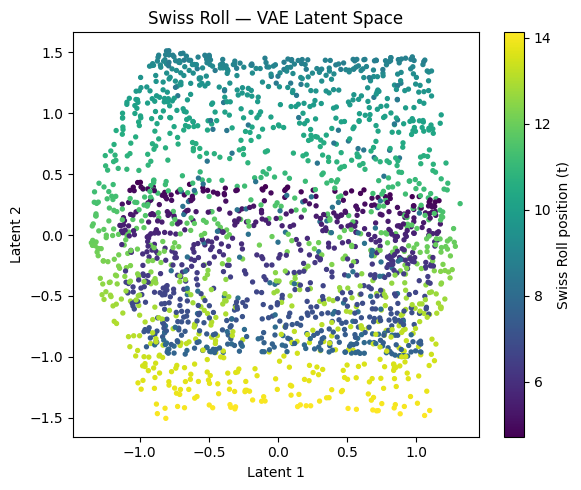

In [19]:
# 6. Extract latent codes
z_mean_val, _, _ = encoder.predict(X, batch_size=128)
plt.figure(figsize=(6,5))
plt.scatter(z_mean_val[:,0], z_mean_val[:,1], c=t_est, cmap='viridis', s=8)
plt.colorbar(label="Swiss Roll position (t)")
plt.xlabel("Latent 1")
plt.ylabel("Latent 2")
plt.title("Swiss Roll — VAE Latent Space")
plt.tight_layout()
plt.show()